<h4>Задание</h4>
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема, к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

<h4>Описание данных</h4>
<li>order_id - id заказа</li>
<li>delivery_time - время доставки в минутах</li>
<li>district - район доставки</li>
<li>experiment_group - экспериментальная группа</li>

In [22]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
delivery = pd.read_csv('experiment.csv')

In [3]:
delivery.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [4]:
delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

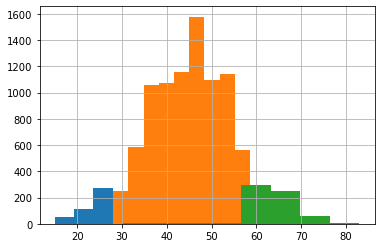

In [8]:
delivery.query('experiment_group == "control"').groupby('district').delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

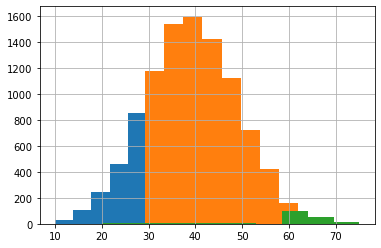

In [9]:
delivery.query('experiment_group == "test"').groupby('district').delivery_time.hist()

In [13]:
print("number of observations in control group =", delivery.query('experiment_group == "control"').experiment_group.count(), "\n",
      "  number of observations in test group =", delivery.query('experiment_group == "test"').experiment_group.count())

number of observations in control group = 10092 
   number of observations in test group = 10104


<font color="teal">Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.</font>

In [18]:
control_group_sample = delivery.query('experiment_group == "control"').delivery_time.sample(1000, random_state=17)

In [19]:
test_group_sample = delivery.query('experiment_group == "test"').delivery_time.sample(1000, random_state=17)

In [20]:
stats.shapiro(control_group_sample) # данные в контрольной группе распределены нормально p > 0.05

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

In [21]:
stats.shapiro(test_group_sample) # данные в тестовой группе распределены нормально p > 0.05

ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)

In [23]:
np.std(delivery.query('experiment_group == "control"').delivery_time)

9.989522000653128

In [24]:
np.std(delivery.query('experiment_group == "test"').delivery_time)

9.882819260031312

In [25]:
control_group = delivery.query('experiment_group == "control"').delivery_time

In [26]:
test_group = delivery.query('experiment_group == "test"').delivery_time

In [28]:
stats.ttest_ind(test_group, control_group)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [31]:
test_group_mean = test_group.mean()
control_group_mean = control_group.mean()

In [32]:
print('test group mean is:', test_group_mean)
print('control group mean is:', control_group_mean)

test group mean is: 39.04681314330958
control group mean is: 45.065101070154576


In [33]:
(test_group_mean - control_group_mean) * 100 / control_group_mean

-13.354653121660812

<b>Вывод</b> : раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.